## Facies classification using Machine Learning


#### Contest entry by: <a href="https://github.com/mycarta">Matteo Niccoli</a> and <a href="__">Mark Dahl</a>


####  [Original contest notebook](../Facies_classification.ipynb) by Brendon Hall, [Enthought](https://www.enthought.com/)

In this notebook we will train a machine learning algorithm to predict facies from well log data.  The dataset comes from a class exercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset consists of log data from nine wells that have been labeled with a facies type based on observation of core. We will use this log data to train a support vector machine to classify facies types. 

### The plan

After a quick exploration of the dataset, we will:
- run cross-validated grid search (with stratified k-fold) for parameter tuning
- look at learning curves to get an idea of bias vs. variance, and under fitting vs. over fitting
- train a new classifier with tuned parameters using leave-one-well-out as a method of testing


### Exploring the dataset

First, we will examine the data set we will use to train the classifier.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, make_scorer

from sklearn.model_selection import LeaveOneGroupOut, validation_curve
import pandas as pd
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

In [2]:
filename = '../facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [3]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

These are the names of the 10 training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone. 

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels, and add those to the `facies_vectors` dataframe.

In [4]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, most values have 4149 valid values except for `PE`, which has 3232.  We will drop the feature vectors that don't have a valid `PE` entry.

In [5]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

In [6]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five log values and two geologic constraining variables, **and we are also using depth**. We also get a vector of the facies labels that correspond to each feature vector.

In [7]:
y = training_data['Facies'].values
print y[25:40]
print np.shape(y)

[3 3 2 2 2 2 2 2 3 3 3 3 3 3 3]
(3232,)


In [8]:
X = training_data.drop(['Formation', 'Well Name','Facies','FaciesLabels'], axis=1)
print np.shape(X)
X.describe(percentiles=[.05, .25, .50, .75, .95])

(3232, 8)


,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
5%,2632.775000,23.491000,0.237299,-5.600000,4.800000,2.523300,1.000000,0.070000
25%,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
95%,3061.500000,106.268000,1.045606,12.000000,27.787400,5.369550,2.000000,0.962000
max,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


###  Stratified K-fold validation to evaluate model performance 
One of the key steps in machine learning is to estimate a model's performance on data that it has not seen before.
Scikit-learn provides a simple utility utility (train_test_split) to partition the data into a training and a test set, but the disadvantage with that is that we ignore a portion of our dataset during training. An additional disadvantage of simple spit, inherent to log data, is that there's a depth dependence. 

A possible strategy to avoid this is cross-validation. With k-fold cross-validation we randomly split the data into k-folds without replacement, where k-1 folds are used for training and one fold for testing. The process is repeated k times, and the performance is obtained by taking the average of the k individual performances.

Stratified k-fold is an improvement over standard k-fold in that the class proportions are preserved in each fold to ensure that each fold is representative of the class proportions in the data.

### Grid search for parameter tuning

Another important aspect of machine learning is the search for the optimal model parameters (i.e. those that will yield the best performance). This tuning is done using grid search.

The above short summary is based on Sebastian Raschka's <a href="https://github.com/rasbt/python-machine-learning-book"> Python Machine Learning</a> book.

In [9]:
from sklearn.model_selection import GridSearchCV

### Two birds with a stone

Below we will perform grid search with stratified K-fold: http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html#sphx-glr-auto-examples-model-selection-grid-search-digits-py.

This will give us reasonable values for the more critical (for performance) classifier's parameters.

### Make performance scorers
Used to evaluate training, testing, and validation performance.

In [10]:
Fscorer = make_scorer(f1_score, average = 'micro')
Ascorer = make_scorer(accuracy_score)

###  SVM classifier
SImilar to the classifier in the article (but, as you will see, it uses a different kernel). We will re-import the data so as to pre-process it as in the tutorial.

In [11]:
from sklearn import svm
SVC_classifier = svm.SVC(cache_size = 800, random_state=1)

In [12]:
training_data = pd.read_csv('../training_data.csv')
X = training_data.drop(['Formation', 'Well Name', 'Facies'], axis=1).values
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
y = training_data['Facies'].values

In [13]:
parm_grid={'kernel': ['linear', 'rbf'],
            'C': [0.5, 1, 5, 10, 15],
            'gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10]}


grid_search = GridSearchCV(SVC_classifier,
                           param_grid=parm_grid,
                           scoring = Fscorer,
                           cv=10) # Stratified K-fold with n_splits=10
                                  # For integer inputs, if the estimator is a
                                  # classifier and y is either binary or multiclass,
                                  # as in our case, StratifiedKFold is used
            
grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.540532178218
Best parameters: {'kernel': 'rbf', 'C': 5, 'gamma': 0.01}


SVC(C=5, cache_size=800, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

### Learning curves

The idea from this point forward is to use the parameters, as tuned above, but to create a brand new classifier for the learning curves exercise. ** This classifier will therefore be well tuned but would not have seen the training data**.

We will look at learning curves of training and (cross-validated) testing error versus number of samples, hoping to gain some insight into whether:
- since we will be testing eventually using a leave one-well-out, would we have enough samples?
- is there a good bias-variance trade-off?  In other words, is the classifier under-fitting, over-fitting, or just right?

The plots are adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html


In [14]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(0.1, 1., 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = Fscorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training F1")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation F1")

    plt.legend(loc="best")
    return plt

First things first, how many samples do we have for each leave-one-well-out split?

In [15]:
training_data = pd.read_csv('../training_data.csv')
X = training_data.drop(['Formation', 'Well Name', 'Facies'], axis=1).values
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
y = training_data['Facies'].values
wells = training_data["Well Name"].values

logo = LeaveOneGroupOut()

for train, test in logo.split(X, y, groups=wells):
    well_name = wells[test[0]]
    print well_name, 'out: ', np.shape(train)[0], 'training samples - ', np.shape(test)[0], 'test samples'


CHURCHMAN BIBLE out:  2828 training samples -  404 test samples
CROSS H CATTLE out:  2731 training samples -  501 test samples
LUKE G U out:  2771 training samples -  461 test samples
NEWBY out:  2769 training samples -  463 test samples
NOLAN out:  2817 training samples -  415 test samples
Recruit F9 out:  3164 training samples -  68 test samples
SHANKLE out:  2783 training samples -  449 test samples
SHRIMPLIN out:  2761 training samples -  471 test samples


On average, we'll have about 2830 samples for training curves and 400 for testing curves.

In [16]:
from sklearn import svm
SVC_classifier_learn = svm.SVC(C=5, cache_size=800, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
training_data = pd.read_csv('../training_data.csv')
X = training_data.drop(['Formation', 'Well Name', 'Facies'], axis=1).values
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
y = training_data['Facies'].values

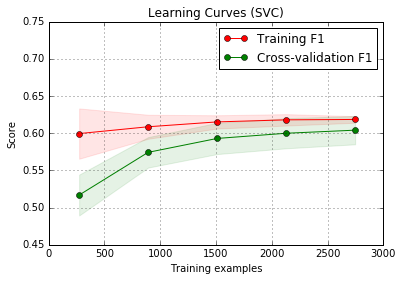

In [18]:
title = "Learning Curves (SVC)"
# Learning curves with 50 iterations to get smoother mean test and train
# score curves; each time we hold 15% of the data randomly as a validation set.
# This is equivalent to leaving about 1 well out, on average (3232 minus ~2800 samples)
cv = ShuffleSplit(n_splits=50, test_size=0.15, random_state=1)

plot_learning_curve(SVC_classifier_learn, title, X, y, cv=cv, ylim=(0.45, 0.75), n_jobs=4)
plt.show()

#### Observations

- Neither training nor cross-validation scores are very high. 
- The scores start to converge at just about the number of samples (on average) we intend to use for training of our final classifier with leave-one-well-out well cross-validation. But there's still a bit of a gap, which may indicate slight over-fitting (variance a bit high). 

Since we cannot address the overfitting by increasing the number of samples (without sacrificing the leave-one-well-out strategy), we can increase regularization a bit by slightly decreasing the parameter C.

In [19]:
SVC_classifier_learn_2 = svm.SVC(C=2, cache_size=800, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

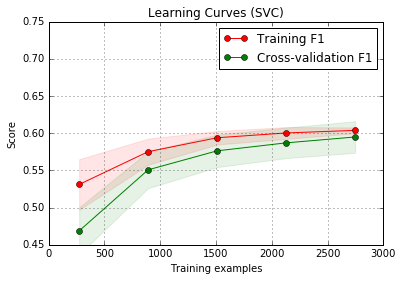

In [20]:
title = "Learning Curves (SVC)"
# Learning curves with 50 iterations to get smoother mean test and train
# score curves; each time we hold 15% of the data randomly as a validation set.
# This is equivalent to leaving about 1 well out, on average (3232 minus ~2800 samples)
cv = ShuffleSplit(n_splits=50, test_size=0.15, random_state=1)

plot_learning_curve(SVC_classifier_learn_2, title, X, y, cv=cv, ylim=(0.45, 0.75), n_jobs=4)
plt.show()

### Confusion matrix 

Let's see how we do with predicting the actual facies, by looking at a confusion matrix. We do this by keeping the parameters from the previous section, but creating a brand new classifier. So when we fit the data, it won't have seen it before.

In [21]:
from sklearn import svm
SVC_classifier_conf = svm.SVC(C=2, cache_size=800, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
svc_pred = SVC_classifier_conf.fit(X,y)
svc_pred = SVC_classifier_conf.predict(X)

from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(svc_pred, y)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   119    22     9                                       150
     CSiS   137   578   232     4     6     1           7         965
     FSiS     3   132   358     1     5     1     1     5         506
     SiSh           1     8   111    26    31    15    15     7   214
       MS                             6     1     1     9          17
       WS           2     3    60   134   319     8   120     9   655
        D                       2     5     3    41     4          55
       PS           3     5     6    35   105    32   322    38   546
       BS                                   1          16   107   124

Precision  0.46  0.78  0.58  0.60  0.03  0.69  0.42  0.65  0.66  0.67
   Recall  0.79  0.60  0.71  0.52  0.35  0.49  0.75  0.59  0.86  0.61
       F1  0.58  0.68  0.64  0.56  0.05  0.57  0.54  0.62  0.75  0.62


### Final classifier

We now train our final classifier with leave-one-well-out validation. Again, we keep the parameters from the previous section, but creating a brand new classifier. So when we fit the data, it won't have seen it before.

In [23]:
from sklearn import svm
SVC_classifier_LOWO = svm.SVC(C=2, cache_size=800, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
training_data = pd.read_csv('../training_data.csv')
X = training_data.drop(['Formation', 'Well Name', 'Facies'], axis=1).values
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
y = training_data['Facies'].values
wells = training_data["Well Name"].values

logo = LeaveOneGroupOut()

f1_SVC = []

for train, test in logo.split(X, y, groups=wells):
    well_name = wells[test[0]]
    SVC_classifier_LOWO.fit(X[train], y[train])
    pred = SVC_classifier_LOWO.predict(X[test])
    sc = f1_score(y[test], pred, labels = np.arange(10), average = 'micro')
    print("{:>20s}  {:.3f}".format(well_name, sc))
    f1_SVC.append(sc)

     CHURCHMAN BIBLE  0.495
      CROSS H CATTLE  0.317
            LUKE G U  0.475
               NEWBY  0.387
               NOLAN  0.520
          Recruit F9  0.515
             SHANKLE  0.483
           SHRIMPLIN  0.537


In [25]:
print "-Average leave-one-well-out F1 Score: %6f" % (sum(f1_SVC)/(1.0*(len(f1_SVC))))

-Average leave-one-well-out F1 Score: 0.466215
